In [1]:
! pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=99a139f0d77799203ac85f22fa2315b8e9440585285ab405a76fd6260453144b
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, date_format, when, udf
from haversine import haversine
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [4]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

In [5]:
df = spark.read.csv('2017_fordgobike_tripdata.csv', inferSchema=True, header=True)
df.count()

519700

In [38]:
df.dtypes

[('start_time', 'string'),
 ('start time hour', 'int'),
 ('start time minute', 'int'),
 ('start time seconds', 'int'),
 ('end_time', 'string'),
 ('end_time hour', 'int'),
 ('end_time minute', 'int'),
 ('end_time seconds', 'int'),
 ('start_station_id', 'int'),
 ('start_station_name', 'string'),
 ('start_station_latitude', 'double'),
 ('start_station_longitude', 'double'),
 ('end_station_id', 'int'),
 ('end_station_name', 'string'),
 ('end_station_latitude', 'double'),
 ('end_station_longitude', 'double'),
 ('bike_id', 'int'),
 ('user_type', 'string'),
 ('member_birth_year', 'int'),
 ('member_gender', 'string'),
 ('pyment', 'string')]

In [6]:
df = df.withColumn('start_time', F.concat_ws(':', "start time hour", "start time minute", "start time seconds"))
df = df.withColumn('end_time', F.concat_ws(':', "end_time hour", "end_time minute", "end_time seconds"))
df.show()

+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+
|start_time|start time hour|start time minute|start time seconds|end_time|end_time hour|end_time minute|end_time seconds|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|
+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------

In [7]:
df = df.withColumn("start_time_timestamp", to_timestamp("start_time"))
df = df.withColumn("start_time_timestamp", date_format("start_time_timestamp", "hh:mm:ss"))
df = df.withColumn("end_time_timestamp", to_timestamp("end_time"))
df = df.withColumn("end_time_timestamp", date_format("end_time_timestamp", "hh:mm:ss"))

In [8]:
df = df.drop("start time hour","start time minute","start time seconds","end_time hour","end_time minute","end_time seconds", "start_time", "end_time")

In [9]:
df = df.withColumn("start_time", when(df.start_time_timestamp < df.end_time_timestamp, df.start_time_timestamp).otherwise(df.end_time_timestamp))
df = df.withColumn("end_time", when(df.start_time_timestamp < df.end_time_timestamp, df.end_time_timestamp).otherwise(df.start_time_timestamp))
df = df.drop("start_time_timestamp", "end_time_timestamp")

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
    start = (lat1, lon1)
    end = (lat2, lon2)
    distance = haversine(start, end)
    return distance

calculate_distance = udf(haversine_distance, DoubleType())

df = df.withColumn("distance", calculate_distance(df.start_station_latitude, df.start_station_longitude, df.end_station_latitude, df.end_station_longitude))

In [11]:
df = df.withColumn("duration_in_seconds", (to_timestamp(df.end_time).cast("long") - to_timestamp(df.start_time).cast("long")))

In [12]:
df = df.withColumn("cost_per_ride", (df.duration_in_seconds/60)*0.35)

In [13]:
bike_mileage = df.groupBy("bike_id").agg(F.sum("distance").alias("mileage"))
bike_mileage = bike_mileage.orderBy("mileage", ascending=False)
display(bike_mileage)

bike_id,mileage
68,743.3694820484665
2178,721.182243221356
256,671.916097882985
235,670.1620031683859
2049,656.828101766426
441,656.6422746252358
2226,647.8232304063756
796,646.8677297229267
190,640.294181741224
2365,639.4126742864064


In [14]:
#calculate the number of trips for each start station list top 10 and find the ratio of using as male or female
# select top ten start stations
start_agg = df.groupBy("start_station_id").count().orderBy("count", ascending=False).limit(10)
display(start_agg)

start_station_id,count
15,15187
6,13664
30,12546
67,12055
58,11960
21,11334
81,10956
3,10142
22,9926
16,9347


In [15]:
# pivot the data to have one row per id with male and female counts
pivoted = df.groupBy("start_station_id").pivot("member_gender").count()
pivoted = pivoted.withColumn("total_trips", pivoted.null + pivoted.Female + pivoted.Male + pivoted.Other)
pivoted = pivoted.drop("Other", "null")
pivoted = pivoted.orderBy("total_trips", ascending=False).limit(10)
# calculate the male to female ratio
ratio = pivoted.withColumn("mtf_ratio", pivoted["Male"] / pivoted["Female"])
display(ratio)

start_station_id,Female,Male,total_trips,mtf_ratio
15,2819,8586,15187,3.045760908123448
6,1938,7444,13664,3.8410732714138285
30,2035,9813,12546,4.822113022113022
67,2105,9409,12055,4.469833729216152
58,1870,9005,11960,4.815508021390374
21,1631,8367,11334,5.1299816063764565
81,2302,7773,10956,3.3766290182450045
3,1768,6070,10142,3.433257918552036
22,1980,7512,9926,3.793939393939394
16,1740,6532,9347,3.754022988505747


In [16]:
#make a comparison to find the percentage of usage for customer and subscriber
#finding ratio per start station
user_type_ratio = df.groupBy("start_station_id").pivot("user_type").count()
user_type_ratio = user_type_ratio.withColumn("total_trips", user_type_ratio.Customer + user_type_ratio.Subscriber)
user_type_ratio = user_type_ratio.withColumn("pct_customer", user_type_ratio.Customer*100 /user_type_ratio.total_trips)
user_type_ratio = user_type_ratio.withColumn("pct_subscriber", user_type_ratio.Subscriber*100 /user_type_ratio.total_trips)
display(user_type_ratio)

start_station_id,Customer,Subscriber,total_trips,pct_customer,pct_subscriber
148,339,451,790,42.91139240506329,57.08860759493671
243,511,2633,3144,16.25318066157761,83.7468193384224
31,548,1029,1577,34.74952441344325,65.25047558655676
251,74,96,170,43.529411764705884,56.470588235294116
137,270,1238,1508,17.90450928381963,82.09549071618036
85,357,1723,2080,17.16346153846154,82.83653846153847
53,672,1239,1911,35.16483516483517,64.83516483516483
133,505,1691,2196,22.996357012750455,77.00364298724955
296,112,539,651,17.204301075268816,82.79569892473118
78,189,1056,1245,15.180722891566266,84.81927710843374


In [17]:
# finding ratio of the entire dataset
agg_user_ratio = df.groupBy("user_type").count()
display(agg_user_ratio)

user_type,count
Subscriber,409230
Customer,110470


In [18]:
total_user_ratio = df.filter(df.user_type == "Customer").count() / df.count()
total_user_ratio

0.21256494131229556

In [19]:
#calculate the age of all users and show the relation between the distance and the age
#add age column
df = df.withColumn("member_age", F.year(F.current_date()) - df.member_birth_year)

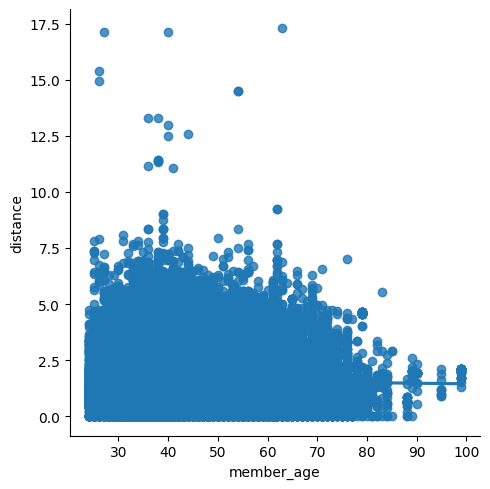

In [53]:
# select two columns, clean data, sample half to not crash pandas, and plot with regression line
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
topandas_df = df.select(["member_age", "distance"])
topandas_df = topandas_df.dropna()
topandas_df = topandas_df.filter(topandas_df.member_age < 100)
topandas_df = topandas_df.filter(topandas_df.distance < 60)
topandas_df = topandas_df.sample(False, 0.5)
pandas_df = topandas_df.toPandas()

sns.lmplot(data=pandas_df, x="member_age", y="distance")


In [54]:
# calculate correlation with clean data
topandas_df.corr("member_age", "distance")

-0.02841698714650042

In [55]:
#calculate the total cost for all customers and all subscribers

cost_user_type = df.groupBy("user_type").agg(F.sum("cost_per_ride"))
display(cost_user_type)

user_type,sum(cost_per_ride)
Subscriber,2462171.920833353
Customer,2354367.814166656


In [56]:
#Analyze how often bikes are being rented ( morning - afternoon - evening) and and find the density for each hour of the day

df_hours = df.groupBy(F.substring(df.start_time, 0, 2).alias("hour")).count().orderBy("hour")
display(df_hours)


hour,count
01,36211
02,26744
03,29511
04,42452
05,62596
06,55235
07,53497
08,73787
09,57102
10,32442


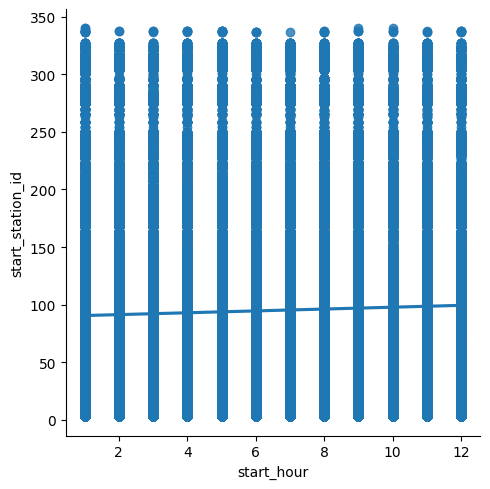

In [57]:
#find if there is a relation between the time and start stations
topandas_df1 = df.select(["start_station_id", F.substring(df.start_time, 0, 2).cast("int").alias("start_hour")])
topandas_df1 = topandas_df1.dropna()
topandas_df1 = topandas_df1.sample(False, 0.5)
#display(topandas_df1)
pandas_df1 = topandas_df1.toPandas()

sns.lmplot(data=pandas_df1, x="start_hour", y="start_station_id")


In [58]:
topandas_df1.corr("start_hour", "start_station_id")

0.027850145879335753

<Axes: xlabel='start_hour', ylabel='count'>

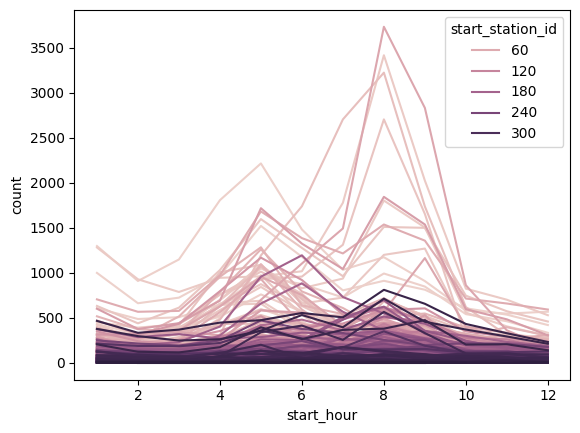

In [59]:
topandas_df2 = df.groupBy(["start_station_id", F.substring(df.start_time, 0, 2).cast("int").alias("start_hour")]).count()
pandas_df2 = topandas_df2.toPandas()

sns.lineplot(data=pandas_df2, x="start_hour", y="count", hue="start_station_id")


In [60]:
#what is the ratio of payment using cc or app wallet
agg_pyment_ratio = df.groupBy("pyment").count()
display(agg_pyment_ratio)

pyment,count
app wallet,260061
credit card,259639


In [61]:
pyment_ratio = df.filter(df.pyment == "app wallet").count() / df.count()
pyment_ratio

0.5004060034635367

In [62]:
#what is the preferred way to pay for customers and subscriber
cust_pyment = df.groupBy(["user_type", "pyment"]).count()
cust_pyment

user_type,pyment,count
Subscriber,app wallet,204727
Customer,app wallet,55334
Customer,credit card,55136
Subscriber,credit card,204503


In [63]:
pyment_pivot = df.groupBy("user_type").pivot("pyment").count()
pyment_pivot

user_type,app wallet,credit card
Subscriber,204727,204503
Customer,55334,55136


In [64]:
#Analyze the relationship between trip duration and user type (subscriber vs. customer) to understand differences in usage patterns.
duration_pivot = df.groupBy("user_type").agg(F.mean("duration_in_seconds"), F.median("duration_in_seconds"), F.min("duration_in_seconds"), F.max("duration_in_seconds"), F.count("user_type"))
duration_pivot

user_type,avg(duration_in_seconds),median(duration_in_seconds),min(duration_in_seconds),max(duration_in_seconds),count(user_type)
Subscriber,1031.4165994672921,531.0,45,43125,409230
Customer,3653.5340907033583,1099.0,5,43040,110470


In [36]:
#Investigate the distribution of trip durations to understand the typical usage patterns and suggest potential pricing structures or promotional offers based on these patterns.
# (example for me most usage time is 10 min what do you suggest for this pattern for price )
df_alt = df.dropna()
trip_durations = df_alt.select("user_type", "duration_in_seconds")
trip_durations = trip_durations.filter(trip_durations.duration_in_seconds < 2000)
#trip_durations.count()

In [37]:
trip_durations_pandas = trip_durations.toPandas()
#trip_durations_pandas = trip_durations_pandas['duration_in_minutes'].apply(lambda x: x/60)

In [38]:
trip_durations_pandas.describe()

,duration_in_seconds
count,436399.000000
mean,623.670655
std,359.805409
min,45.000000
25%,359.000000
50%,543.000000
75%,803.000000
max,1999.000000


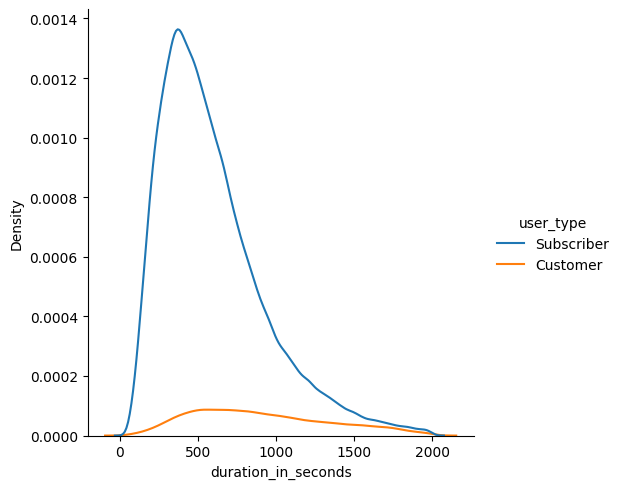

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.displot(data=trip_durations_pandas, x="duration_in_seconds", hue="user_type", kind="kde")

In [141]:
#Identify the most popular routes by combining start and end station information and suggest potential improvements to the bike network based on these findings
df_x = df.groupBy(["start_station_id", "end_station_id"]).count().orderBy("count", ascending=False)
df_x

start_station_id,end_station_id,count
15,6,3344
6,16,1793
6,15,1734
81,15,1686
48,21,1509
21,48,1485
15,81,1401
16,6,1361
50,15,1274
182,196,1196
